In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. Load and preprocess (your existing function)
def load_and_prepare(path, suffix):
    df = pd.read_csv(path, parse_dates=['valid_time'])
    df = df.sort_values('valid_time')
    df['tp'] *= 1000  # m to mm
    df['tp'] = np.log1p(df['tp'])  # log transform precipitation
    df = df[['valid_time', 'u10', 'v10', 't2m', 'sp', 'tp']]
    df.columns = ['valid_time'] + [f'{col}_{suffix}' for col in df.columns if col != 'valid_time']
    return df

# Load data for each region
df_center = load_and_prepare('data/brazil.csv', 'center')
df_north = load_and_prepare('data/brazil_north.csv', 'north')
df_south = load_and_prepare('data/brazil_south.csv', 'south')
df_east  = load_and_prepare('data/brazil_east.csv', 'east')
df_west  = load_and_prepare('data/brazil_west.csv', 'west')

# Merge on valid_time
df = df_center.merge(df_north, on='valid_time')
df = df.merge(df_south, on='valid_time')
df = df.merge(df_east, on='valid_time')
df = df.merge(df_west, on='valid_time')
df = df.sort_values('valid_time').reset_index(drop=True)

# 2. Add cyclical time features
df['dayofyear'] = df['valid_time'].dt.dayofyear
df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)

# 3. Define features to scale (meteorological variables only)
center_features = ['u10_center', 'v10_center', 't2m_center', 'sp_center', 'tp_center']
north_features = [f"{feat}_north" for feat in ['u10', 'v10', 't2m', 'sp', 'tp']]
south_features = [f"{feat}_south" for feat in ['u10', 'v10', 't2m', 'sp', 'tp']]
east_features  = [f"{feat}_east"  for feat in ['u10', 'v10', 't2m', 'sp', 'tp']]
west_features  = [f"{feat}_west"  for feat in ['u10', 'v10', 't2m', 'sp', 'tp']]

all_meteorological_features = center_features + north_features + south_features + east_features + west_features

# 4. Train-test split index (time based)
train_size = int(0.6 * len(df))

# # 5. Fit scaler on training only
scaler = StandardScaler()
scaler.fit(df.loc[:train_size-1, all_meteorological_features])


# # Store original scaled target for inverse transform later
tp_scaler = StandardScaler()
df['tp_center_scaled'] = tp_scaler.fit_transform(df[['tp_center']])

# # 6. Transform entire dataset (train+val+test)
df[all_meteorological_features] = scaler.transform(df[all_meteorological_features])


# 7. Generate lag, rolling, diff features *after* scaling on tp_center ONLY
lags = [1, 3, 6, 12, 24]
rolling_windows = [3, 6, 12]

for lag in lags:
    df[f'tp_lag_{lag}h'] = df['tp_center'].shift(lag)
for window in rolling_windows:
    df[f'tp_roll_mean_{window}h'] = df['tp_center'].rolling(window).mean()

df['tp_diff_1h'] = df['tp_center'].diff(1)

# 8. Drop NaNs generated by lag/rolling
df.dropna(inplace=True)

# 9. Features for model input: meteorological + cyclical + lags/roll/diff
cyclical_features = ['dayofyear_sin', 'dayofyear_cos']
lag_features = [f'tp_lag_{lag}h' for lag in lags]
roll_features = [f'tp_roll_mean_{w}h' for w in rolling_windows]
diff_features = ['tp_diff_1h']

feature_cols = all_meteorological_features + cyclical_features + lag_features + roll_features + diff_features

print(f"Final feature columns count: {len(feature_cols)}")

# 10. Sequence creation function
def create_sequences(df, seq_len=360, horizon=7):
    X, y = [], []
    for i in range(seq_len, len(df) - horizon):
        X_seq = df.iloc[i - seq_len:i][feature_cols].values
        y_seq = df.iloc[i:i + horizon]['tp_center_scaled'].values

        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y)

# Create sequences for forecasting
sequence_length = 360
forecast_horizon = 7
X, y = create_sequences(df, sequence_length, forecast_horizon)

print(f"X shape: {X.shape}, y shape: {y.shape}")


Final feature columns count: 36
X shape: (61001, 360, 36), y shape: (61001, 7)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization, MultiHeadAttention, Add, Concatenate
from tensorflow.keras.models import Model

def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe, dtype=tf.float32)


def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.5 * mse + 0.5 * mae

def spike_weighted_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 2.0, 1.0)  # spike = tp > 1 mm
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


# Transformer Encoder block (same as before)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Encoder for a single region (shared params)
def build_region_encoder(seq_len, feature_dim, conv_filters=32, kernel_size=3,
                         head_size=16, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Conv1D(conv_filters, kernel_size, padding='causal', activation='relu')(inputs)
    pos_encoding = get_positional_encoding(seq_len, conv_filters)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    model = Model(inputs, x)
    return model

import tensorflow as tf

def split_features_by_region(X, feature_names):
    regions = ['center', 'north', 'south', 'east', 'west']
    region_feats = {r: [] for r in regions}

    for idx, name in enumerate(feature_names):
        matched = False
        for r in regions:
            if r in name:
                region_feats[r].append(idx)
                matched = True
                break
        if not matched:
            region_feats['center'].append(idx)  # put engineered features in 'center'

    # Use tf.gather on symbolic tensor to select features
    region_inputs = {}
    for r, idxs in region_feats.items():
        region_inputs[r] = tf.keras.layers.Lambda(
            lambda x, idxs=idxs: tf.gather(x, indices=idxs, axis=2)
        )(X)

    return region_inputs


# Build the full fusion model
def build_multi_encoder_fusion(seq_len, feature_names,
                               conv_filters=32, kernel_size=3,
                               head_size=16, num_heads=2, ff_dim=64,
                               num_layers=1, dropout=0.1, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))
    region_inputs = split_features_by_region(inputs, feature_names)

    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # --- MULTI-TASK OUTPUTS ---
    output_regress = Dense(forecast_horizon, name='tp_amount')(x)
    output_classify = Dense(forecast_horizon, activation='sigmoid', name='rain_prob')(x)

    model = Model(inputs, outputs=[output_regress, output_classify])
    return model



# === Usage Example ===
model = build_multi_encoder_fusion(sequence_length, feature_cols)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': hybrid_loss,
        'rain_prob': 'binary_crossentropy'
    },
    loss_weights={
        'tp_amount': 1.0,
        'rain_prob': 0.3
    }
)

model.summary()


# Train-test split for sequences
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Define rain threshold in log1p space (e.g. 0.5 mm)
rain_threshold = np.log1p(0.5)

# Create binary rain label
y_rain = (y > rain_threshold).astype(int)

# Train/val/test split for binary rain labels
y_rain_train = y_rain[:train_size]
y_rain_val = y_rain[train_size:train_size + val_size]
y_rain_test = y_rain[train_size + val_size:]


early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    {'tp_amount': y_train, 'rain_prob': y_rain_train},
    validation_data=(X_val, {'tp_amount': y_val, 'rain_prob': y_rain_val}),
    epochs=20,
    batch_size=16,
    callbacks=[early_stop]
)



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360, 36)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 360, 16)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 32)        │     10,112 │ lambda[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 32)        │      9,056 │ lambda_1[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 32)        │      9,056 │ lambda_2[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 32)        │      9,056 │ lambda_3[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 32)        │      9,056 │ lambda_4[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ functional[0][0], │
│ (Concatenate)       │                   │            │ functional_1[0][… │
│                     │                   │            │ functional_2[0][… │
│                     │                   │            │ functional_3[0][… │
│                     │                   │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 160)       │          0 │ concatenate[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     41,216 │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tp_amount (Dense)   │ (None, 7)         │      1,799 │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rain_prob (Dense)   │ (None, 7)         │      1,799 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 91,150 (356.05 KB)

 Trainable params: 91,150 (356.05 KB)

 Non-trainable params: 0 (0.00 B)

2288/2288 ━━━━━━━━━━━━━━━━━━━━ 303s 128ms/step - loss: 1.0326 - rain_prob_loss: 0.5238 - tp_amount_loss: 0.8755 - val_loss: 0.8397 - val_rain_prob_loss: 0.4129 - val_tp_amount_loss: 0.7153


In [3]:
# Step 1: Find the index of 'tp_center' in your feature list
tp_center_index = all_meteorological_features.index('tp_center')

# Step 2: Create dummy feature arrays to inverse transform only tp_center
def inverse_transform_tp(pred_scaled):
    dummy = np.zeros((pred_scaled.shape[0], len(all_meteorological_features)))
    dummy[:, tp_center_index] = pred_scaled
    tp_inv = scaler.inverse_transform(dummy)[:, tp_center_index]
    return np.expm1(tp_inv)  # reverse log1p

y_pred_tp, y_pred_rain = model.predict(X_test)


# Apply to predictions and targets
y_pred_final = inverse_transform_tp(y_pred_tp.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

from sklearn.metrics import r2_score

for day in range(7):
    r2 = r2_score(y_test_final[day::7], y_pred_final[day::7])
    print(f"Day {day + 1} R²: {r2:.3f}")


382/382 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step
Day 1 R²: 0.008
Day 2 R²: 0.010
Day 3 R²: 0.005
Day 4 R²: 0.007
Day 5 R²: 0.000
Day 6 R²: 0.006
Day 7 R²: 0.005


In [4]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

for day in range(7):
    y_true_day = y_test_final[day::7]
    y_pred_day = y_pred_final[day::7]

    r2 = r2_score(y_true_day, y_pred_day)
    mse = mean_squared_error(y_true_day, y_pred_day)
    mae = mean_absolute_error(y_true_day, y_pred_day)

    print(f"Day {day + 1} R²: {r2:.3f} | MSE: {mse:.3f} | MAE: {mae:.3f}")


Day 1 R²: 0.008 | MSE: 0.775 | MAE: 0.262
Day 2 R²: 0.010 | MSE: 0.773 | MAE: 0.268
Day 3 R²: 0.005 | MSE: 0.777 | MAE: 0.260
Day 4 R²: 0.007 | MSE: 0.775 | MAE: 0.264
Day 5 R²: 0.000 | MSE: 0.780 | MAE: 0.258
Day 6 R²: 0.006 | MSE: 0.776 | MAE: 0.260
Day 7 R²: 0.005 | MSE: 0.776 | MAE: 0.264


In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)
tp_preds = tp_scaler.inverse_transform(preds[0])
rain_preds = (preds[1] > 0.5).astype(int)

print(classification_report(y_rain_test.flatten(), rain_preds.flatten()))


169/382 ━━━━━━━━━━━━━━━━━━━━ 14s 68ms/step

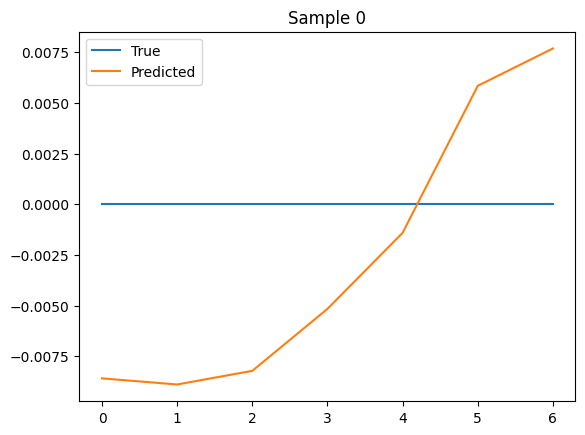

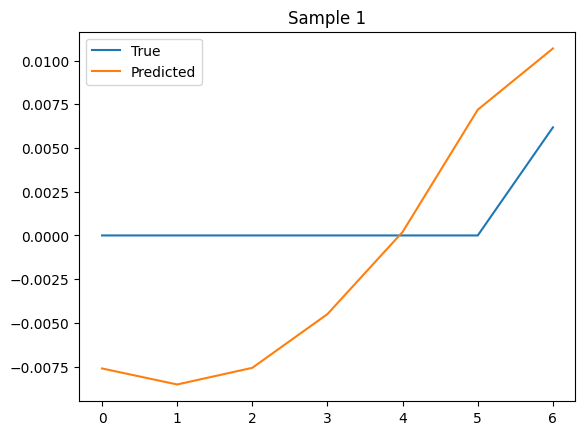

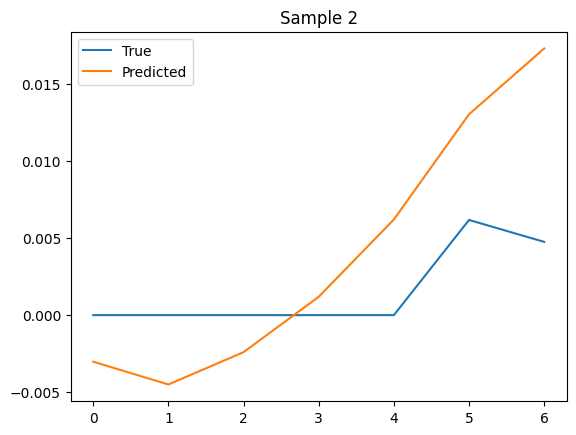

In [ ]:
import matplotlib.pyplot as plt

for i in range(3):
    plt.plot(tp_scaler.inverse_transform(y_test[i].reshape(-1, 1)), label='True')
    plt.plot(tp_scaler.inverse_transform(preds[0][i].reshape(-1, 1)), label='Predicted')
    plt.title(f'Sample {i}')
    plt.legend()
    plt.show()


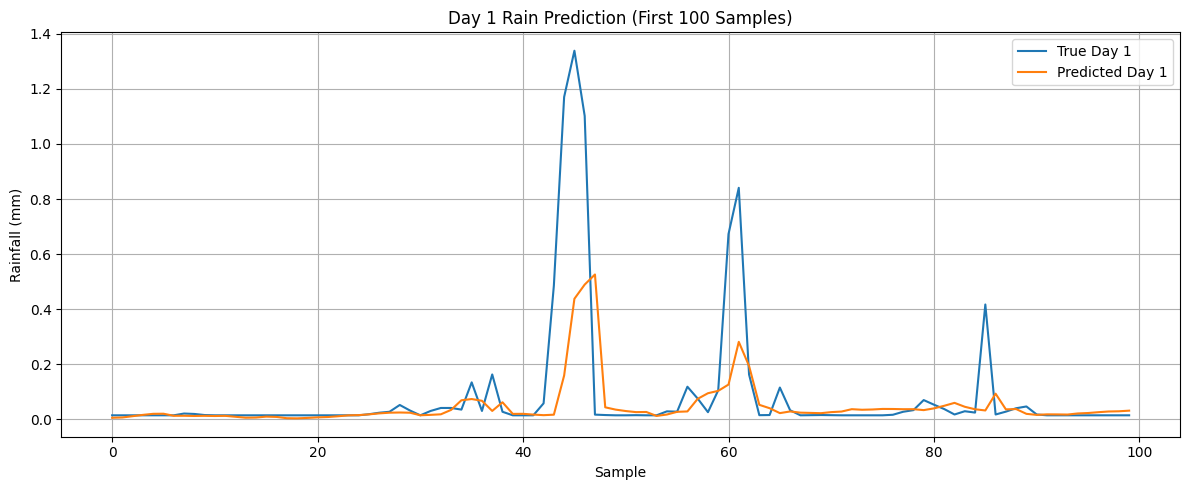

In [ ]:
import matplotlib.pyplot as plt


# Select first 100 Day 1 predictions and true values
y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final[::7][:100]



plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
################ side note, different itterations capture different spikes, maybe use various models for various spikes? how to decide? meta classifier or something else to capture the hints and use appropriate model!!!!

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization, MultiHeadAttention, Add, Concatenate
from tensorflow.keras.models import Model

def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe, dtype=tf.float32)


def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.5 * mse + 0.5 * mae

def spike_weighted_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 2.0, 1.0)  # spike = tp > 1 mm
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

def spike_scaled_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 5.0, 1.0)  # emphasize large spikes
    loss = tf.square(y_true - y_pred)
    return tf.reduce_mean(weights * loss)

def exp_output_layer(x):
    return tf.keras.layers.Lambda(lambda x: tf.math.expm1(x))(x)


# Transformer Encoder block (same as before)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Encoder for a single region (shared params)
def build_region_encoder(seq_len, feature_dim, conv_filters=32, kernel_size=3,
                         head_size=16, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Conv1D(conv_filters, kernel_size, padding='causal', activation='relu')(inputs)
    pos_encoding = get_positional_encoding(seq_len, conv_filters)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    model = Model(inputs, x)
    return model

import tensorflow as tf

def split_features_by_region(X, feature_names):
    regions = ['center', 'north', 'south', 'east', 'west']
    region_feats = {r: [] for r in regions}

    for idx, name in enumerate(feature_names):
        matched = False
        for r in regions:
            if r in name:
                region_feats[r].append(idx)
                matched = True
                break
        if not matched:
            region_feats['center'].append(idx)  # put engineered features in 'center'

    # Use tf.gather on symbolic tensor to select features
    region_inputs = {}
    for r, idxs in region_feats.items():
        region_inputs[r] = tf.keras.layers.Lambda(
            lambda x, idxs=idxs: tf.gather(x, indices=idxs, axis=2)
        )(X)

    return region_inputs


# Build the full fusion model
def build_multi_encoder_fusion(seq_len, feature_names,
                               conv_filters=32, kernel_size=3,
                               head_size=16, num_heads=2, ff_dim=64,
                               num_layers=1, dropout=0.1, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))
    region_inputs = split_features_by_region(inputs, feature_names)

    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # Regression head
    tp_amount = Dense(forecast_horizon, name='tp_amount')(x)

    # Classification heads
    light_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='light_rain_prob')(x)
    medium_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='medium_rain_prob')(x)
    heavy_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='heavy_rain_prob')(x)

    # Define model with multiple outputs
    model = Model(inputs, [tp_amount, light_rain_prob, medium_rain_prob, heavy_rain_prob])

    # # --- MULTI-TASK OUTPUTS ---
    # output_regress = Dense(forecast_horizon, name='tp_amount')(x)
    # output_classify = Dense(forecast_horizon, activation='sigmoid', name='rain_prob')(x)

    # model = Model(inputs, outputs=[output_regress, output_classify])
    return model



# === Usage Example ===
model = build_multi_encoder_fusion(sequence_length, feature_cols)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': spike_scaled_loss,
        'light_rain_prob': 'binary_crossentropy',
        'medium_rain_prob': 'binary_crossentropy',
        'heavy_rain_prob': 'binary_crossentropy',

    },
    
    loss_weights={
        'tp_amount': 1.0,
        'light_rain_prob': 0.1,
        'medium_rain_prob': 0.2,
        'heavy_rain_prob': 0.3,
    }
)


model.summary()


# Train-test split for sequences
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Define rain threshold in log1p space (e.g. 0.5 mm)
rain_threshold = np.log1p(0.5)

# Create binary rain label
y_rain = (y > rain_threshold).astype(int)

# In original mm units (reverse log1p)
y_mm = np.expm1(y)

# Multi-threshold binary labels
# Thresholds already in log1p units
y_light = (y > 0.4).astype(np.float32)
y_medium = (y > 0.8).astype(np.float32)
y_heavy = (y > 1.2).astype(np.float32)


y_dict = {
    'tp_amount': y,  # still log1p-scaled
    'light_rain_prob': y_light,
    'medium_rain_prob': y_medium,
    'heavy_rain_prob': y_heavy,
}


# Train/val/test split for binary rain labels
y_rain_train = y_rain[:train_size]
y_rain_val = y_rain[train_size:train_size + val_size]
y_rain_test = y_rain[train_size + val_size:]


early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        'tp_amount': y_train,
        'light_rain_prob': y_light[:len(X_train)],
        'medium_rain_prob': y_medium[:len(X_train)],
        'heavy_rain_prob': y_heavy[:len(X_train)],
    },
    validation_data=(
        X_val,
        {
            'tp_amount': y_val,
            'light_rain_prob': y_light[len(X_train):len(X_train)+len(X_val)],
            'medium_rain_prob': y_medium[len(X_train):len(X_train)+len(X_val)],
            'heavy_rain_prob': y_heavy[len(X_train):len(X_train)+len(X_val)],
        }
    ),
    epochs=7,
    batch_size=16,
    callbacks=[early_stop]
)


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 360, 36)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 360, 16)   │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 360, 5)    │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ (None, 32)        │     10,112 │ lambda_5[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 32)        │      9,056 │ lambda_6[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_8        │ (None, 32)        │      9,056 │ lambda_7[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 32)        │      9,056 │ lambda_8[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_10       │ (None, 32)        │      9,056 │ lambda_9[0][0]    │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ functional_6[0][… │
│ (Concatenate)       │                   │            │ functional_7[0][… │
│                     │                   │            │ functional_8[0][… │
│                     │                   │            │ functional_9[0][… │
│                     │                   │            │ functional_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 160)       │          0 │ concatenate_1[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 256)       │     41,216 │ dropout_42[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_43          │ (None, 256)       │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tp_amount (Dense)   │ (None, 7)         │      1,799 │ dropout_43[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ light_rain_prob     │ (None, 7)         │      1,799 │ dropout_43[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_rain_prob    │ (None, 7)         │      1,799 │ dropout_43[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 94,748 (370.11 KB)

 Trainable params: 94,748 (370.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 383s 156ms/step - heavy_rain_prob_loss: 0.4290 - light_rain_prob_loss: 0.5647 - loss: 3.7834 - medium_rain_prob_loss: 0.5164 - tp_amount_loss: 3.4949 - val_heavy_rain_prob_loss: 0.3064 - val_light_rain_prob_loss: 0.4293 - val_loss: 3.2661 - val_medium_rain_prob_loss: 0.3627 - val_tp_amount_loss: 3.0567
Epoch 2/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 355s 155ms/step - heavy_rain_prob_loss: 0.3428 - light_rain_prob_loss: 0.4754 - loss: 3.4969 - medium_rain_prob_loss: 0.4042 - tp_amount_loss: 3.2657 - val_heavy_rain_prob_loss: 0.2903 - val_light_rain_prob_loss: 0.4087 - val_loss: 3.2056 - val_medium_rain_prob_loss: 0.3458 - val_tp_amount_loss: 3.0064
Epoch 3/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 382s 155ms/step - heavy_rain_prob_loss: 0.3373 - light_rain_prob_loss: 0.4579 - loss: 3.3088 - medium_rain_prob_loss: 0.3937 - tp_amount_loss: 3.0830 - val_heavy_rain_prob_loss: 0.2678 - val_light_rain_prob_loss: 0.3724 - val_loss: 2.7434 - val_medium_rain_prob_loss: 0

In [ ]:
# Step 1: Find the index of 'tp_center' in your feature list
tp_center_index = all_meteorological_features.index('tp_center')

# Step 2: Create dummy feature arrays to inverse transform only tp_center
def inverse_transform_tp(pred_scaled):
    dummy = np.zeros((pred_scaled.shape[0], len(all_meteorological_features)))
    dummy[:, tp_center_index] = pred_scaled
    tp_inv = scaler.inverse_transform(dummy)[:, tp_center_index]
    return np.expm1(tp_inv)  # reverse log1p

y_pred_tp, y_pred_light, y_pred_medium, y_pred_heavy = model.predict(X_test)

# Then inverse-transform tp_center as before:
y_pred_final = inverse_transform_tp(y_pred_tp.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

from sklearn.metrics import r2_score

for day in range(7):
    r2 = r2_score(y_test_final[day::7], y_pred_final[day::7])
    print(f"Day {day + 1} R²: {r2:.3f}")

382/382 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step
Day 1 R²: 0.340
Day 2 R²: 0.171
Day 3 R²: 0.081
Day 4 R²: 0.049
Day 5 R²: 0.048
Day 6 R²: 0.026
Day 7 R²: 0.012


In [ ]:
def eval_rain_accuracy(y_true_final, y_pred_final, threshold):
    y_true_bin = (y_true_final > threshold).astype(int)
    y_pred_bin = (y_pred_final > threshold).astype(int)
    from sklearn.metrics import precision_score, recall_score
    p = precision_score(y_true_bin, y_pred_bin)
    r = recall_score(y_true_bin, y_pred_bin)
    return p, r

for thresh in [0.1, 2.0, 5.0]:
    p, r = eval_rain_accuracy(y_test_final, y_pred_final, thresh)
    print(f"> {thresh}mm Rain: Precision={p:.2f}, Recall={r:.2f}")


> 0.1mm Rain: Precision=0.31, Recall=0.96
> 2.0mm Rain: Precision=0.44, Recall=0.10
> 5.0mm Rain: Precision=0.00, Recall=0.00


c:\Users\justa\ML\Weather\.venv-3.12\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


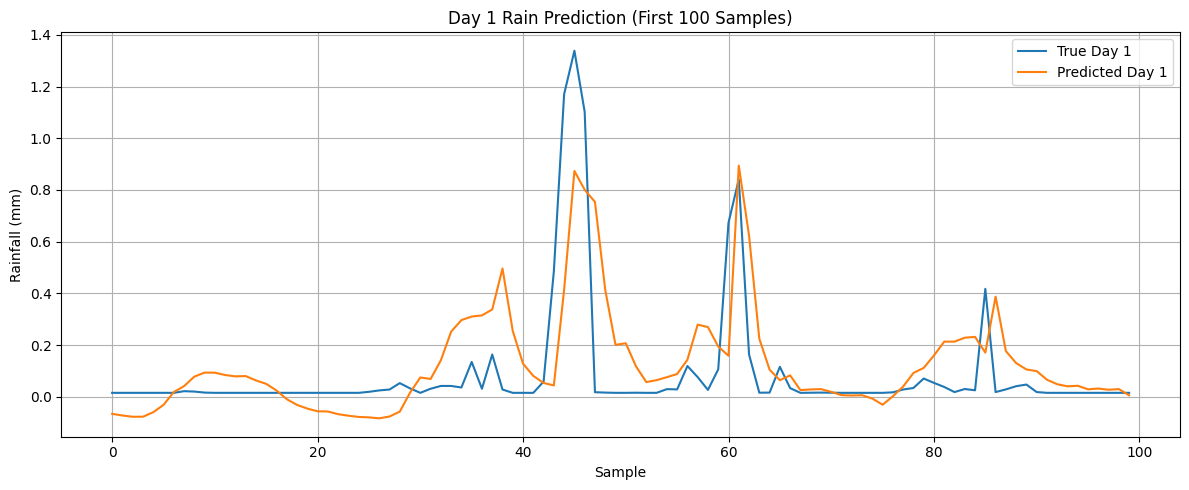

In [ ]:
import matplotlib.pyplot as plt


# Select first 100 Day 1 predictions and true values
y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final[::7][:100]



plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ok alternatively
how about we get 2 models
one predicts the spikes/rain which it does well!
however when the rain is low and the model would do badly, another model that is optimised for that kicks in!
in essence, can we somehow make the program recognise, hey there is signs of little rain, this model should handle it, there is signs of a spike incoming, lets let this model handle it?
ie the tasks are delagated to various models based on the early signs?

ChatGPT said:
Yes — this idea is very viable and it's known as a Mixture of Experts (MoE) approach. You're essentially proposing a smart routing mechanism that dynamically delegates prediction tasks to the model that’s best suited for a particular regime (e.g., dry vs. rainy conditions).

🔁 Your Idea in Structure:
🎯 Specialized Experts
Model A (Spike Expert): Trained to handle moderate-to-heavy rain (peaks, non-zero regions).

Model B (Light/Dry Expert): Trained to handle light/no-rain situations accurately.

🧠 Gating Network (Router):
A lightweight classifier that looks at the input sequence and decides which model’s output to trust more for each forecast timestep (or even each sample).

The routing can be:

Hard: Choose one expert (binary decision).

Soft: Take a weighted average between experts' predictions (e.g., 80% spike expert, 20% dry expert).

🧠 Why This Can Work for You
You're observing:

Spike model = excellent at rain onset/spike timing, bad at light/dry.

Another model = good at quiet/no-rain, misses intensity of actual spikes.

So splitting the responsibility, and allowing the model to adapt dynamically, can preserve your spike performance while solving the "too much rain where there's none" problem.

✅ Implementation Path
1. Train Two Experts Separately
python
Copy
Edit
# Expert A (spike)
# You can oversample rain sequences or use weighted loss
model_spike = train_model(X_train, y_train, condition="rainy")

# Expert B (dry/light)
# Emphasize dry sequences or use masked MSE loss
model_dry = train_model(X_train, y_train, condition="dry")
You can split the training data beforehand based on total rainfall (e.g., sequences where tp.sum(axis=1) > threshold).

2. Train the Gating Model
Train a small classifier to predict whether a sample is likely to be a spike:

python
Copy
Edit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D

gate = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    GlobalAveragePooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # outputs confidence in "spike"
])

# Labels: 1 for spike (e.g., max tp > 0.5 mm), 0 otherwise
rain_label = (np.expm1(y_train).max(axis=1) > 0.5).astype(np.float32)

gate.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gate.fit(X_train, rain_label, epochs=10, batch_size=32, validation_split=0.2)
3. Predict with Soft Gating
At test time:

python
Copy
Edit
spike_pred = model_spike.predict(X_test)
dry_pred = model_dry.predict(X_test)

gate_weights = gate.predict(X_test).reshape(-1, 1)  # shape (N, 1)

# Option 1: Broadcast across 7 days
gate_weights = np.repeat(gate_weights, 7, axis=1)

# Weighted average of the two experts
final_pred = gate_weights * spike_pred + (1 - gate_weights) * dry_pred
You can clamp final_pred = np.maximum(final_pred, 0) to remove negatives.

🔄 Bonus: Make Gate Condition-Aware
Train the gating model using features like RH, pressure, etc. that show early signs of rain onset.

Optionally, make the gate timestep-aware (e.g., predict a gate value per day in forecast horizon).

✅ Summary
Component	Purpose
model_spike	Captures rain spikes, even if over-predicting
model_dry	Handles clear/light rain days well
gate	Decides how much to trust each model per input

This delegation strategy can let you preserve peak performance while reducing false alarms. If you'd like, I can help you build the training data splitter and the final MoE prediction pipeline.

Would you like to try this step-by-step, starting with how to define the training sets for the two experts?

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization, MultiHeadAttention, Add, Concatenate
from tensorflow.keras.models import Model

def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe, dtype=tf.float32)


def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.5 * mse + 0.5 * mae

def spike_weighted_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 2.0, 1.0)  # spike = tp > 1 mm
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

def spike_scaled_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 5.0, 1.0)  # emphasize large spikes
    loss = tf.square(y_true - y_pred)
    return tf.reduce_mean(weights * loss)

def exp_output_layer(x):
    return tf.keras.layers.Lambda(lambda x: tf.math.expm1(x))(x)


def spike_smooth_loss(y_true, y_pred):
    # Emphasize true rainfall > 0.8 with a smooth ramp-up
    weights = 1.0 + 4.0 * tf.sigmoid(5.0 * (y_true - 0.8))
    loss = tf.square(tf.maximum(0.0, y_true) - tf.maximum(0.0, y_pred))  # avoid negatives
    return tf.reduce_mean(weights * loss)

def anti_bias_loss(y_true, y_pred):
    over_preds = tf.nn.relu(y_pred - y_true)
    return tf.reduce_mean(over_preds)

def custom_total_loss(y_true, y_pred):
    return spike_smooth_loss(y_true, y_pred) + 0.2 * anti_bias_loss(y_true, y_pred)

# Transformer Encoder block (same as before)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Encoder for a single region (shared params)
def build_region_encoder(seq_len, feature_dim, conv_filters=32, kernel_size=3,
                         head_size=16, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Conv1D(conv_filters, kernel_size, padding='causal', activation='relu')(inputs)
    pos_encoding = get_positional_encoding(seq_len, conv_filters)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    model = Model(inputs, x)
    return model

import tensorflow as tf

def split_features_by_region(X, feature_names):
    regions = ['center', 'north', 'south', 'east', 'west']
    region_feats = {r: [] for r in regions}

    for idx, name in enumerate(feature_names):
        matched = False
        for r in regions:
            if r in name:
                region_feats[r].append(idx)
                matched = True
                break
        if not matched:
            region_feats['center'].append(idx)  # put engineered features in 'center'

    # Use tf.gather on symbolic tensor to select features
    region_inputs = {}
    for r, idxs in region_feats.items():
        region_inputs[r] = tf.keras.layers.Lambda(
            lambda x, idxs=idxs: tf.gather(x, indices=idxs, axis=2)
        )(X)

    return region_inputs


# Build the full fusion model
def build_multi_encoder_fusion(seq_len, feature_names,
                               conv_filters=32, kernel_size=3,
                               head_size=16, num_heads=2, ff_dim=64,
                               num_layers=1, dropout=0.1, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))
    region_inputs = split_features_by_region(inputs, feature_names)

    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # Regression head
    tp_amount = Dense(forecast_horizon, name='tp_amount')(x)

    # Classification heads
    light_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='light_rain_prob')(x)
    medium_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='medium_rain_prob')(x)
    heavy_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='heavy_rain_prob')(x)

    # Define model with multiple outputs
    model = Model(inputs, [tp_amount, light_rain_prob, medium_rain_prob, heavy_rain_prob])

    # # --- MULTI-TASK OUTPUTS ---
    # output_regress = Dense(forecast_horizon, name='tp_amount')(x)
    # output_classify = Dense(forecast_horizon, activation='sigmoid', name='rain_prob')(x)

    # model = Model(inputs, outputs=[output_regress, output_classify])
    return model



# === Usage Example ===
model = build_multi_encoder_fusion(sequence_length, feature_cols)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': custom_total_loss,  # <--- new loss
        'light_rain_prob': 'binary_crossentropy',
        'medium_rain_prob': 'binary_crossentropy',
        'heavy_rain_prob': 'binary_crossentropy',
    },
    loss_weights={
        'tp_amount': 1.0,
        'light_rain_prob': 0.1,
        'medium_rain_prob': 0.2,
        'heavy_rain_prob': 0.3,
    }
)


model.summary()


# Train-test split for sequences
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Define rain threshold in log1p space (e.g. 0.5 mm)
rain_threshold = np.log1p(0.5)

# Create binary rain label
y_rain = (y > rain_threshold).astype(int)

# In original mm units (reverse log1p)
y_mm = np.expm1(y)

# Multi-threshold binary labels
# Thresholds already in log1p units
y_light = (y > 0.4).astype(np.float32)
y_medium = (y > 0.8).astype(np.float32)
y_heavy = (y > 1.2).astype(np.float32)


y_dict = {
    'tp_amount': y,  # still log1p-scaled
    'light_rain_prob': y_light,
    'medium_rain_prob': y_medium,
    'heavy_rain_prob': y_heavy,
}


# Train/val/test split for binary rain labels
y_rain_train = y_rain[:train_size]
y_rain_val = y_rain[train_size:train_size + val_size]
y_rain_test = y_rain[train_size + val_size:]


early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        'tp_amount': y_train,
        'light_rain_prob': y_light[:len(X_train)],
        'medium_rain_prob': y_medium[:len(X_train)],
        'heavy_rain_prob': y_heavy[:len(X_train)],
    },
    validation_data=(
        X_val,
        {
            'tp_amount': y_val,
            'light_rain_prob': y_light[len(X_train):len(X_train)+len(X_val)],
            'medium_rain_prob': y_medium[len(X_train):len(X_train)+len(X_val)],
            'heavy_rain_prob': y_heavy[len(X_train):len(X_train)+len(X_val)],
        }
    ),
    epochs=7,
    batch_size=16,
    callbacks=[early_stop]
)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 360, 36)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 360, 16)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_12       │ (None, 32)        │     10,112 │ lambda_10[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 32)        │      9,056 │ lambda_11[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_14       │ (None, 32)        │      9,056 │ lambda_12[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 32)        │      9,056 │ lambda_13[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_16       │ (None, 32)        │      9,056 │ lambda_14[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 160)       │          0 │ functional_12[0]… │
│ (Concatenate)       │                   │            │ functional_13[0]… │
│                     │                   │            │ functional_14[0]… │
│                     │                   │            │ functional_15[0]… │
│                     │                   │            │ functional_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 160)       │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     41,216 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 256)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tp_amount (Dense)   │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ light_rain_prob     │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ medium_rain_prob    │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 94,748 (370.11 KB)

 Trainable params: 94,748 (370.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 382s 156ms/step - heavy_rain_prob_loss: 0.3969 - light_rain_prob_loss: 0.5525 - loss: 3.5853 - medium_rain_prob_loss: 0.4873 - tp_amount_loss: 3.3135 - val_heavy_rain_prob_loss: 0.3031 - val_light_rain_prob_loss: 0.4304 - val_loss: 3.1290 - val_medium_rain_prob_loss: 0.3662 - val_tp_amount_loss: 2.9199
Epoch 2/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 353s 154ms/step - heavy_rain_prob_loss: 0.3433 - light_rain_prob_loss: 0.4752 - loss: 3.3938 - medium_rain_prob_loss: 0.4043 - tp_amount_loss: 3.1625 - val_heavy_rain_prob_loss: 0.2916 - val_light_rain_prob_loss: 0.4119 - val_loss: 3.0978 - val_medium_rain_prob_loss: 0.3475 - val_tp_amount_loss: 2.8977
Epoch 3/7
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 355s 155ms/step - heavy_rain_prob_loss: 0.3395 - light_rain_prob_loss: 0.4705 - loss: 3.3142 - medium_rain_prob_loss: 0.4014 - tp_amount_loss: 3.0850 - val_heavy_rain_prob_loss: 0.2779 - val_light_rain_prob_loss: 0.3901 - val_loss: 2.9365 - val_medium_rain_prob_loss: 0

KeyboardInterrupt: 

382/382 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step
📊 R² Scores (Inverse Transformed):
Day 1 R²: -0.078
Day 2 R²: 0.165
Day 3 R²: 0.111
Day 4 R²: 0.076
Day 5 R²: 0.061
Day 6 R²: 0.050
Day 7 R²: 0.032


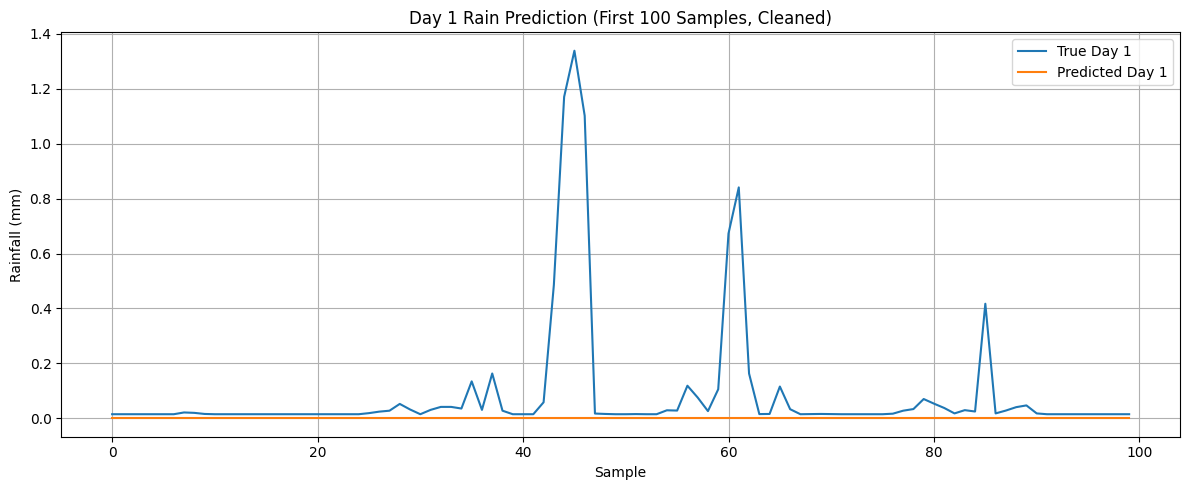

In [ ]:
# Step 1: Find the index of 'tp_center' in your feature list
tp_center_index = all_meteorological_features.index('tp_center')

# Step 2: Inverse-transform only 'tp_center'
def inverse_transform_tp(pred_scaled):
    dummy = np.zeros((pred_scaled.shape[0], len(all_meteorological_features)))
    dummy[:, tp_center_index] = pred_scaled
    tp_inv = scaler.inverse_transform(dummy)[:, tp_center_index]
    return np.expm1(tp_inv)  # reverse log1p

# Step 3: Get model predictions
y_pred_tp, y_pred_light, y_pred_medium, y_pred_heavy = model.predict(X_test)

# Step 4: Inverse-transform predictions and ground truth
y_pred_final = inverse_transform_tp(y_pred_tp.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

# === Clamp negative predictions to 0
y_pred_final = np.clip(y_pred_final, 0.0, None)

# === Optional: Remove light rain noise (< 0.2 mm)
y_pred_final_clean = np.where(y_pred_final < 0.2, 0.0, y_pred_final)

# === R² Scores (you can switch between `y_pred_final_clean` or `y_pred_final`)
from sklearn.metrics import r2_score

print("📊 R² Scores (Inverse Transformed):")
for day in range(7):
    r2 = r2_score(y_test_final[day::7], y_pred_final_clean[day::7])
    print(f"Day {day + 1} R²: {r2:.3f}")

# === Plot Day 1 (first 100 samples)
import matplotlib.pyplot as plt

y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final_clean[::7][:100]

plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples, Cleaned)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Find the index of 'tp_center' in your feature list
tp_center_index = all_meteorological_features.index('tp_center')

# Step 2: Create dummy feature arrays to inverse transform only tp_center
def inverse_transform_tp(pred_scaled):
    dummy = np.zeros((pred_scaled.shape[0], len(all_meteorological_features)))
    dummy[:, tp_center_index] = pred_scaled
    tp_inv = scaler.inverse_transform(dummy)[:, tp_center_index]
    return np.expm1(tp_inv)  # reverse log1p

y_pred_tp, y_pred_light, y_pred_medium, y_pred_heavy = model.predict(X_test)

# Then inverse-transform tp_center as before:
y_pred_final = inverse_transform_tp(y_pred_tp.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

from sklearn.metrics import r2_score

for day in range(7):
    r2 = r2_score(y_test_final[day::7], y_pred_final[day::7])
    print(f"Day {day + 1} R²: {r2:.3f}")


382/382 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step
Day 1 R²: -0.448
Day 2 R²: 0.079
Day 3 R²: 0.062
Day 4 R²: 0.016
Day 5 R²: 0.013
Day 6 R²: 0.013
Day 7 R²: -0.012


In [ ]:
### perhaps have it so that if the model makes low prediction, let other model handel it, etc. overarching baseline model that dictates which model is to be used?

### or maybe if final model captures peaks fairly well, maybe do a residual corrector applied to the mistakes?

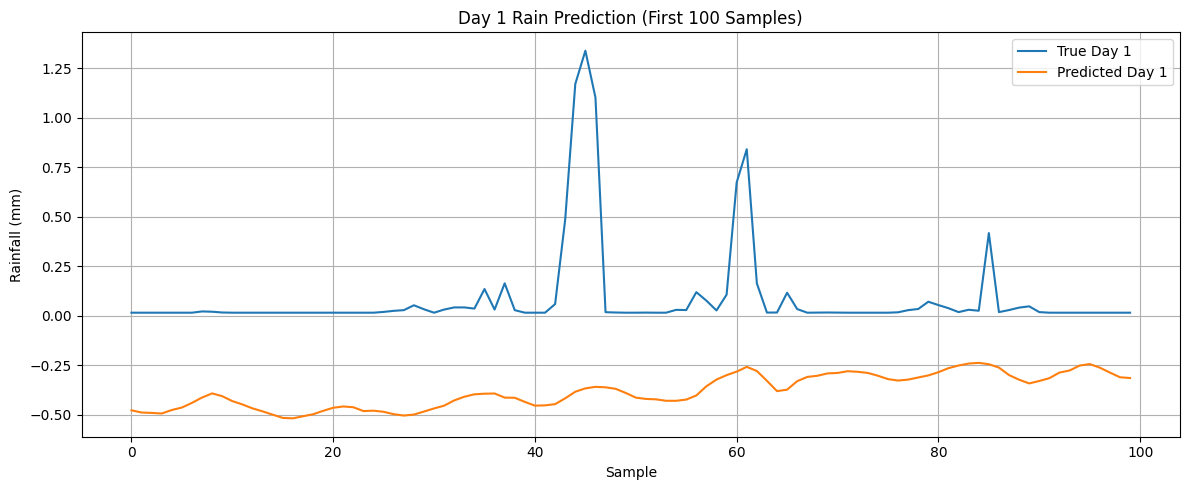

In [ ]:
import matplotlib.pyplot as plt

# Select first 100 Day 1 predictions and true values
y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final[::7][:100]

plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
########################### Trying to catch smaller spikes better #############################

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# === Updated Custom Loss (Part 1) ===
def spike_smooth_loss_v2(y_true, y_pred):
    # Emphasize smaller spikes (>0.4 instead of >0.8)
    weights = 1.0 + 4.0 * tf.sigmoid(5.0 * (y_true - 0.4))
    loss = tf.square(tf.maximum(0.0, y_true) - tf.maximum(0.0, y_pred))
    return tf.reduce_mean(weights * loss)

def anti_bias_loss(y_true, y_pred):
    over_preds = tf.nn.relu(y_pred - y_true)
    return tf.reduce_mean(over_preds)

def custom_total_loss_v2(y_true, y_pred):
    return spike_smooth_loss_v2(y_true, y_pred) + 0.2 * anti_bias_loss(y_true, y_pred)

# === Modified Model Builder (Part 2) ===
def build_multi_encoder_fusion_with_residual(seq_len, feature_names,
                                              conv_filters=32, kernel_size=3,
                                              head_size=16, num_heads=2, ff_dim=64,
                                              num_layers=1, dropout=0.1, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))

    # Split by region
    region_inputs = split_features_by_region(inputs, feature_names)

    # Region encoders
    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # === Heads ===

    # # Main regression: total rainfall
    # tp_amount = Dense(forecast_horizon, name='tp_amount')(x)

    # # Residual regression head (focus on small-scale variation)
    # tp_residual = Dense(forecast_horizon, name='tp_residual')(x)
    # Updated output heads with softplus

    #change the heads since model preidcts negative, if clamping, only solving the symptom not the cause
    tp_amount = Dense(forecast_horizon, activation='softplus', name='tp_amount')(x)
    tp_residual = Dense(forecast_horizon, activation='softplus', name='tp_residual')(x)


    # Classification heads
    light_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='light_rain_prob')(x)
    medium_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='medium_rain_prob')(x)
    heavy_rain_prob = Dense(forecast_horizon, activation='sigmoid', name='heavy_rain_prob')(x)

    model = Model(inputs, [tp_amount, tp_residual, light_rain_prob, medium_rain_prob, heavy_rain_prob])
    return model

# === Compile the model ===
model = build_multi_encoder_fusion_with_residual(
    sequence_length, feature_cols,
    forecast_horizon=forecast_horizon
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': custom_total_loss_v2,      # updated spike loss
        'tp_residual': 'mse',                   # simple MSE for residuals
        'light_rain_prob': 'binary_crossentropy',
        'medium_rain_prob': 'binary_crossentropy',
        'heavy_rain_prob': 'binary_crossentropy',
    },
    loss_weights={
        'tp_amount': 1.0,
        'tp_residual': 0.5,  # tune this as needed
        'light_rain_prob': 0.1,
        'medium_rain_prob': 0.2,
        'heavy_rain_prob': 0.3,
    }
)

model.summary()


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 360, 36)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 360, 16)   │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_12       │ (None, 32)        │     10,112 │ lambda_10[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_13       │ (None, 32)        │      9,056 │ lambda_11[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_14       │ (None, 32)        │      9,056 │ lambda_12[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_15       │ (None, 32)        │      9,056 │ lambda_13[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_16       │ (None, 32)        │      9,056 │ lambda_14[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 160)       │          0 │ functional_12[0]… │
│ (Concatenate)       │                   │            │ functional_13[0]… │
│                     │                   │            │ functional_14[0]… │
│                     │                   │            │ functional_15[0]… │
│                     │                   │            │ functional_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_64          │ (None, 160)       │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 256)       │     41,216 │ dropout_64[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 256)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tp_amount (Dense)   │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tp_residual (Dense) │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ light_rain_prob     │ (None, 7)         │      1,799 │ dropout_65[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 96,547 (377.14 KB)

 Trainable params: 96,547 (377.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Smoothed version (12h rolling mean of tp_center_scaled)
tp_smoothed = pd.Series(y.flatten()).rolling(window=12, min_periods=1, center=True).mean().values
tp_residual = y.flatten() - tp_smoothed

# Reshape for multi-step forecast shape
tp_residual = tp_residual.reshape(y.shape)

# Update training targets
y_dict = {
    'tp_amount': y,
    'tp_residual': tp_residual,
    'light_rain_prob': y_light,
    'medium_rain_prob': y_medium,
    'heavy_rain_prob': y_heavy,
}


In [ ]:
history = model.fit(
    X_train,
    {key: val[:len(X_train)] for key, val in y_dict.items()},
    validation_data=(
        X_val,
        {key: val[len(X_train):len(X_train)+len(X_val)] for key, val in y_dict.items()}
    ),
    epochs=8,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 423s 185ms/step - heavy_rain_prob_loss: 0.3871 - light_rain_prob_loss: 0.5026 - loss: 3.6123 - medium_rain_prob_loss: 0.4258 - tp_amount_loss: 3.1072 - tp_residual_loss: 0.5072 - val_heavy_rain_prob_loss: 0.2883 - val_light_rain_prob_loss: 0.4117 - val_loss: 3.2271 - val_medium_rain_prob_loss: 0.3461 - val_tp_amount_loss: 2.8247 - val_tp_residual_loss: 0.4072
Epoch 2/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 399s 174ms/step - heavy_rain_prob_loss: 0.3378 - light_rain_prob_loss: 0.4714 - loss: 3.5102 - medium_rain_prob_loss: 0.4006 - tp_amount_loss: 3.0353 - tp_residual_loss: 0.4927 - val_heavy_rain_prob_loss: 0.2910 - val_light_rain_prob_loss: 0.4072 - val_loss: 3.1817 - val_medium_rain_prob_loss: 0.3443 - val_tp_amount_loss: 2.7799 - val_tp_residual_loss: 0.4059
Epoch 3/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 377s 165ms/step - heavy_rain_prob_loss: 0.3250 - light_rain_prob_loss: 0.4465 - loss: 3.2308 - medium_rain_prob_loss: 0.3806 - tp_amount_loss: 2.7730 - t

In [ ]:
# === Predict with the model ===
y_pred_amount, y_pred_residual, _, _, _ = model.predict(X_test)

# === Combine the predictions ===
y_pred_combined = y_pred_amount + y_pred_residual

# === Inverse transform to mm ===
y_pred_final = inverse_transform_tp(y_pred_combined.reshape(-1))  # mm
y_test_final = inverse_transform_tp(y_test.reshape(-1))           # mm


382/382 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step


In [ ]:
# Gating to prevent constant 0.25 prediction

In [ ]:
# Get model outputs
y_pred_amount, y_pred_residual, y_pred_light, _, _ = model.predict(X_test)

# Combine regression predictions
y_pred_combined = y_pred_amount + y_pred_residual

# Apply soft gating (multiply by probability of rain)
y_pred_gated = y_pred_combined * y_pred_light  # shape: (samples, 7)

# Inverse transform
y_pred_final = inverse_transform_tp(y_pred_gated.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

# HARD gate: only allow prediction if rain_prob > 0.4
gate_threshold = 0.4
rain_gate = (y_pred_light > gate_threshold).astype(float)
y_pred_gated = y_pred_combined * rain_gate

# Inverse transform to mm
y_pred_final = inverse_transform_tp(y_pred_gated.reshape(-1))


382/382 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step


In [ ]:
y_pred_final = inverse_transform_tp(y_pred_combined.reshape(-1))
rain_gate = (y_pred_light.reshape(-1) > 0.4).astype(float)
y_pred_final_clamped = y_pred_final * rain_gate


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("\n=== Forecast Performance (Day by Day) ===")
for day in range(7):
    y_true_day = y_test_final[day::7]
    y_pred_day = y_pred_final[day::7]
    
    r2 = r2_score(y_true_day, y_pred_day)
    mae = mean_absolute_error(y_true_day, y_pred_day)
    rmse = np.sqrt(mean_squared_error(y_true_day, y_pred_day))
    
    print(f"Day {day + 1}  |  R²: {r2:.3f}  |  MAE: {mae:.3f} mm  |  RMSE: {rmse:.3f} mm")



=== Forecast Performance (Day by Day) ===
Day 1  |  R²: 0.328  |  MAE: 0.382 mm  |  RMSE: 0.724 mm
Day 2  |  R²: 0.201  |  MAE: 0.422 mm  |  RMSE: 0.790 mm
Day 3  |  R²: 0.125  |  MAE: 0.431 mm  |  RMSE: 0.826 mm
Day 4  |  R²: 0.085  |  MAE: 0.448 mm  |  RMSE: 0.845 mm
Day 5  |  R²: 0.053  |  MAE: 0.466 mm  |  RMSE: 0.860 mm
Day 6  |  R²: 0.016  |  MAE: 0.496 mm  |  RMSE: 0.876 mm
Day 7  |  R²: -0.025  |  MAE: 0.525 mm  |  RMSE: 0.894 mm


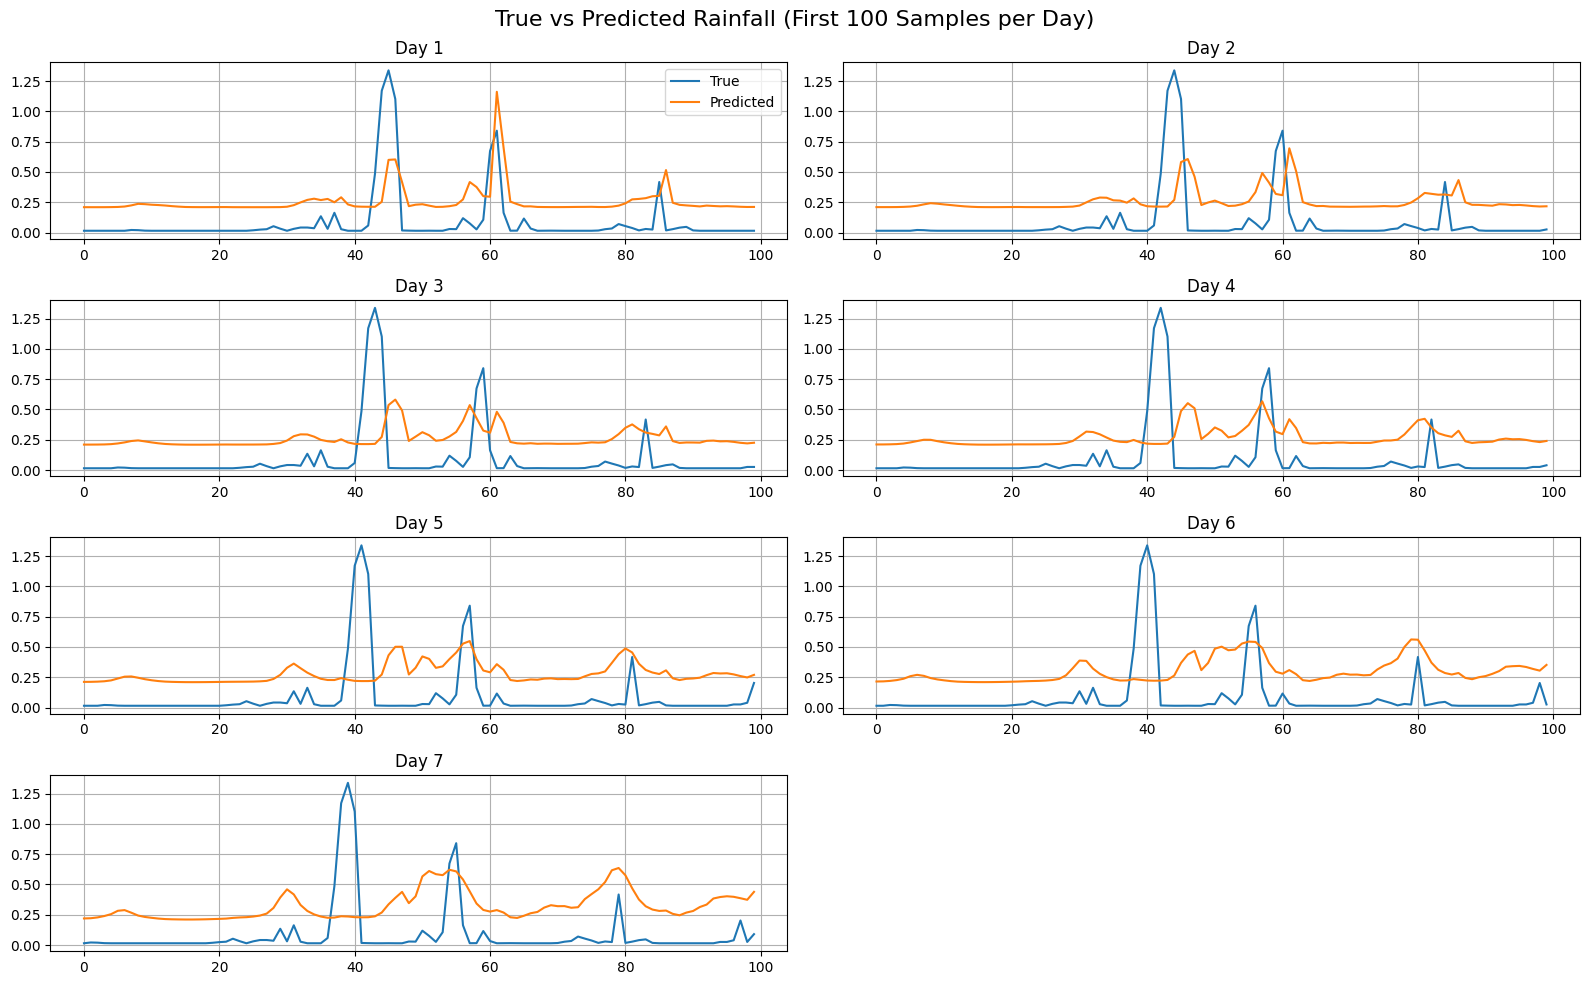

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))
for day in range(7):
    y_true = y_test_final[day::7][:100]
    y_pred = y_pred_final[day::7][:100]
    
    plt.subplot(4, 2, day + 1)
    plt.plot(y_true, label='True')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'Day {day + 1}')
    plt.grid(True)
    if day == 0:
        plt.legend()
        
plt.suptitle("True vs Predicted Rainfall (First 100 Samples per Day)", fontsize=16)
plt.tight_layout()
plt.show()


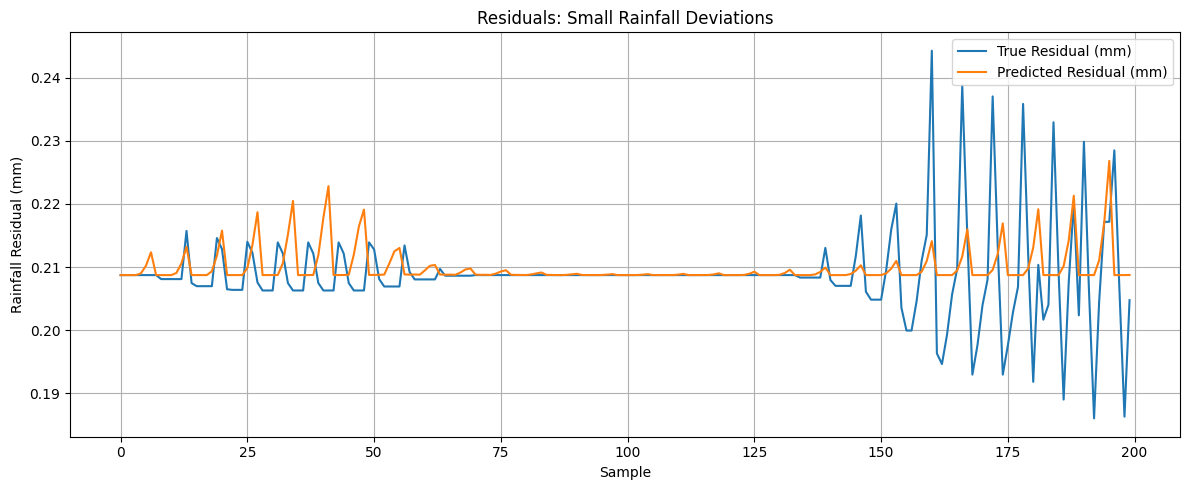

In [ ]:
# Calculate residuals from ground truth
tp_smoothed = pd.Series(y_test.flatten()).rolling(window=12, min_periods=1, center=True).mean().values
tp_residual_true = y_test.flatten() - tp_smoothed

# Reshape predictions to match shape
y_pred_residual_flat = y_pred_residual.reshape(-1)

# Inverse transform both to mm
residual_true_mm = inverse_transform_tp(tp_residual_true)
residual_pred_mm = inverse_transform_tp(y_pred_residual_flat)

# Plot residual comparison (first 200)
plt.figure(figsize=(12, 5))
plt.plot(residual_true_mm[:200], label="True Residual (mm)")
plt.plot(residual_pred_mm[:200], label="Predicted Residual (mm)")
plt.title("Residuals: Small Rainfall Deviations")
plt.xlabel("Sample")
plt.ylabel("Rainfall Residual (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Masked reg function to deal with constant pred of 0.25

In [ ]:
import tensorflow as tf

# === MASKED REGRESSION LOSS ===
def masked_regression_loss(y_true, y_pred):
    rain_threshold = np.log1p(0.1)  # 0.1 mm in log1p space
    rain_mask = tf.cast(y_true > rain_threshold, tf.float32)

    mse = tf.square(y_true - y_pred)
    masked_mse = mse * rain_mask

    return tf.reduce_sum(masked_mse) / (tf.reduce_sum(rain_mask) + 1e-6)


# === MODEL COMPILE WITH MASKED REGRESSION ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': masked_regression_loss,
        'tp_residual': masked_regression_loss,
        'light_rain_prob': 'binary_crossentropy',
        'medium_rain_prob': 'binary_crossentropy',
        'heavy_rain_prob': 'binary_crossentropy',
    },
    loss_weights={
        'tp_amount': 1.0,
        'tp_residual': 0.5,
        'light_rain_prob': 0.2,
        'medium_rain_prob': 0.2,
        'heavy_rain_prob': 0.2,
    }
)


# === EARLY STOPPING AND TRAINING ===
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    {
        'tp_amount': y_train,
        'tp_residual': y_train,  # residual also predicts same target (spike refinement)
        'light_rain_prob': y_light[:len(X_train)],
        'medium_rain_prob': y_medium[:len(X_train)],
        'heavy_rain_prob': y_heavy[:len(X_train)],
    },
    validation_data=(
        X_val,
        {
            'tp_amount': y_val,
            'tp_residual': y_val,
            'light_rain_prob': y_light[len(X_train):len(X_train)+len(X_val)],
            'medium_rain_prob': y_medium[len(X_train):len(X_train)+len(X_val)],
            'heavy_rain_prob': y_heavy[len(X_train):len(X_train)+len(X_val)],
        }
    ),
    epochs=8,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 373s 158ms/step - heavy_rain_prob_loss: 0.3139 - light_rain_prob_loss: 0.4276 - loss: 2.6538 - medium_rain_prob_loss: 0.3646 - tp_amount_loss: 1.4270 - tp_residual_loss: 2.0111 - val_heavy_rain_prob_loss: 0.2526 - val_light_rain_prob_loss: 0.3626 - val_loss: 1.7956 - val_medium_rain_prob_loss: 0.3032 - val_tp_amount_loss: 1.0706 - val_tp_residual_loss: 1.0802
Epoch 2/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 328s 143ms/step - heavy_rain_prob_loss: 0.2896 - light_rain_prob_loss: 0.4101 - loss: 2.3120 - medium_rain_prob_loss: 0.3461 - tp_amount_loss: 1.3921 - tp_residual_loss: 1.4215 - val_heavy_rain_prob_loss: 0.2504 - val_light_rain_prob_loss: 0.3587 - val_loss: 1.7901 - val_medium_rain_prob_loss: 0.3004 - val_tp_amount_loss: 1.0685 - val_tp_residual_loss: 1.0770
Epoch 3/8
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 310s 136ms/step - heavy_rain_prob_loss: 0.2861 - light_rain_prob_loss: 0.4053 - loss: 2.2437 - medium_rain_prob_loss: 0.3409 - tp_amount_loss: 1.3506 - t

382/382 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step
=== Forecast Performance (Day by Day) ===
Day 1  |  R²: -1.339  |  MAE: 0.988 mm  |  RMSE: 1.351 mm
Day 2  |  R²: -1.873  |  MAE: 1.212 mm  |  RMSE: 1.497 mm
Day 3  |  R²: -2.266  |  MAE: 1.283 mm  |  RMSE: 1.597 mm
Day 4  |  R²: -2.960  |  MAE: 1.400 mm  |  RMSE: 1.758 mm
Day 5  |  R²: -3.598  |  MAE: 1.514 mm  |  RMSE: 1.894 mm
Day 6  |  R²: -3.460  |  MAE: 1.473 mm  |  RMSE: 1.866 mm
Day 7  |  R²: -3.477  |  MAE: 1.512 mm  |  RMSE: 1.869 mm


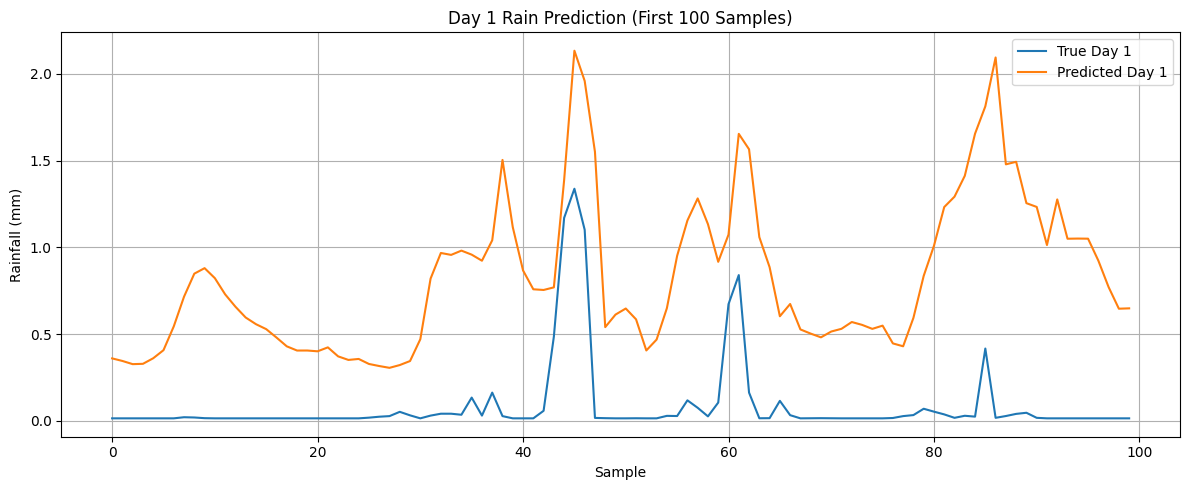

In [ ]:
# === INFERENCE ===
y_pred_amount, y_pred_residual, y_pred_light, _, _ = model.predict(X_test)

# Combine regression predictions (freely)
y_pred_combined = y_pred_amount + y_pred_residual

# Inverse transform to mm
y_pred_final = inverse_transform_tp(y_pred_combined.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

# === METRICS ===
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print("=== Forecast Performance (Day by Day) ===")
for day in range(7):
    y_true_day = y_test_final[day::7]
    y_pred_day = y_pred_final[day::7]

    r2 = r2_score(y_true_day, y_pred_day)
    mae = mean_absolute_error(y_true_day, y_pred_day)
    rmse = np.sqrt(mean_squared_error(y_true_day, y_pred_day))

    print(f"Day {day+1}  |  R²: {r2:.3f}  |  MAE: {mae:.3f} mm  |  RMSE: {rmse:.3f} mm")

# === PLOT FIRST 100 DAY 1 SAMPLES ===
import matplotlib.pyplot as plt

y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final[::7][:100]

plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# maybe introduce a 4th class, no rain? if nothing else, we are LOGICALLY forcing the classifier to predict that there will be rain in the logic flow. if current approach doesn't work, go back to first spike aware constant rain and implement this idea

#side note, explicitly store the relationship between wind x humiditity etc? increase complexity of wind movement and then maybe pressure humidity etc. 

################## DIFFERENT APPROACH TO BE EXPLORED AFTER IN NEW FILE #####################
# if wind and pressure dictates rain, perhaps model these first and then find the relationship between rainfall???

In [ ]:
def build_multi_encoder_fusion(
    seq_len,
    feature_names,
    conv_filters=32,
    kernel_size=3,
    head_size=16,
    num_heads=2,
    ff_dim=64,
    num_layers=1,
    dropout=0.1,
    forecast_horizon=7
):
    # === INPUT ===
    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))  # [B, T, F]

    # === SPLIT FEATURES BY REGION ===
    region_inputs = split_features_by_region(inputs, feature_names)

    # === ENCODERS FOR EACH REGION ===
    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(
            seq_len=seq_len,
            feature_dim=region_inputs[region].shape[-1],
            conv_filters=conv_filters,
            kernel_size=kernel_size,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout
        )
        encoded = encoder(region_inputs[region])
        encoded_outputs.append(encoded)

    # === FUSION ===
    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # === REGRESSION HEAD ===
    tp_amount = Dense(forecast_horizon, name='tp_amount')(x)

    # === OPTIONAL RESIDUAL HEAD (can help correct bias) ===
    tp_residual = Dense(forecast_horizon, name='tp_residual')(x)

    # === CLASSIFICATION HEAD: 4-CLASS CATEGORICAL ===
    rain_class = Dense(forecast_horizon * 4, name='rain_class_logits')(x)
    rain_class = tf.keras.layers.Reshape((forecast_horizon, 4), name='rain_class')(rain_class)
    rain_class = tf.keras.layers.Softmax(axis=-1)(rain_class)

    # === FINAL MODEL ===
    model = tf.keras.Model(inputs=inputs, outputs=[tp_amount, tp_residual, rain_class])
    return model


In [ ]:
# Rebuild the model with updated architecture (new rain_class output)
model = build_multi_encoder_fusion(sequence_length, feature_cols)

# Now compile it
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': masked_regression_loss,
        'tp_residual': masked_regression_loss,
        'rain_class': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    },
    loss_weights={
        'tp_amount': 1.0,
        'tp_residual': 0.5,
        'rain_class': 0.3,
    }
)


In [ ]:
# === 4-CLASS RAIN CATEGORIZATION ===
# Convert log1p-scaled y back to mm for classification
y_mm = np.expm1(y)

# Create discrete classes
# 0: No rain (≤ 0.1mm)
# 1: Light (0.1–0.4)
# 2: Medium (0.4–1.2)
# 3: Heavy (>1.2)
def categorize_rain(y_mm):
    y_class = np.zeros_like(y_mm, dtype=np.int32)
    y_class[(y_mm > 0.1) & (y_mm <= 0.4)] = 1
    y_class[(y_mm > 0.4) & (y_mm <= 1.2)] = 2
    y_class[y_mm > 1.2] = 3
    return y_class

y_class = categorize_rain(y_mm)

# Train/val/test splits
y_class_train = y_class[:train_size]
y_class_val = y_class[train_size:train_size + val_size]
y_class_test = y_class[train_size + val_size:]


In [ ]:
def build_multi_encoder_fusion(
    seq_len,
    feature_names,
    conv_filters=32,
    kernel_size=3,
    head_size=16,
    num_heads=2,
    ff_dim=64,
    num_layers=1,
    dropout=0.1,
    forecast_horizon=7
):
    # === INPUT ===
    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))  # [B, T, F]

    # === SPLIT FEATURES BY REGION ===
    region_inputs = split_features_by_region(inputs, feature_names)

    # === ENCODERS FOR EACH REGION ===
    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(
            seq_len=seq_len,
            feature_dim=region_inputs[region].shape[-1],
            conv_filters=conv_filters,
            kernel_size=kernel_size,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            num_layers=num_layers,
            dropout=dropout
        )
        encoded = encoder(region_inputs[region])
        encoded_outputs.append(encoded)

    # === FUSION ===
    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)

    # === REGRESSION HEAD ===
    tp_amount = Dense(forecast_horizon, name='tp_amount')(x)

    # === OPTIONAL RESIDUAL HEAD (can help correct bias) ===
    tp_residual = Dense(forecast_horizon, name='tp_residual')(x)

    # === CLASSIFICATION HEAD: 4-CLASS CATEGORICAL ===
    rain_class = Dense(forecast_horizon * 4, name='rain_class_logits')(x)
    rain_class = tf.keras.layers.Reshape((forecast_horizon, 4), name='rain_class')(rain_class)
    rain_class = tf.keras.layers.Softmax(axis=-1)(rain_class)

    # === FINAL MODEL ===
    model = tf.keras.Model(inputs=inputs, outputs=[tp_amount, tp_residual, rain_class])
    return model

In [ ]:
# === COMPILE MODEL ===
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        'tp_amount': masked_regression_loss,
        'tp_residual': masked_regression_loss,
        'rain_class': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    },
    loss_weights={
        'tp_amount': 1.0,
        'tp_residual': 0.5,
        'rain_class': 0.3,
    }
)

# === EARLY STOPPING ===
early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# === TRAINING ===
history = model.fit(
    X_train,
    {
        'tp_amount': y_train,
        'tp_residual': y_train,
        'rain_class': y_class_train,
    },
    validation_data=(
        X_val,
        {
            'tp_amount': y_val,
            'tp_residual': y_val,
            'rain_class': y_class_val,
        }
    ),
    epochs=7,
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/7


ValueError: Expected keys ListWrapper(['tp_amount', 'tp_residual', 'softmax_20']) in loss dict, but found loss.keys()=['tp_amount', 'tp_residual', 'rain_class']

In [ ]:
# === PREDICTIONS ===
y_pred_amount, y_pred_residual, y_pred_class_logits = model.predict(X_test)

# Combine regression heads
y_pred_combined = y_pred_amount + y_pred_residual
y_pred_final = inverse_transform_tp(y_pred_combined.reshape(-1))
y_test_final = inverse_transform_tp(y_test.reshape(-1))

# === CLASSIFICATION ACCURACY ===
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Argmax across 4 class probs (axis=-1)
y_pred_class = np.argmax(y_pred_class_logits, axis=-1)
y_class_test_flat = y_class_test.flatten()
y_pred_class_flat = y_pred_class.flatten()

print("\n=== Classification Accuracy ===")
print(f"Accuracy: {accuracy_score(y_class_test_flat, y_pred_class_flat):.3f}")
print(classification_report(y_class_test_flat, y_pred_class_flat, target_names=[
    "No Rain", "Light", "Medium", "Heavy"
]))

# === PLOT DAY 1 ===
import matplotlib.pyplot as plt

y_true_day1 = y_test_final[::7][:100]
y_pred_day1 = y_pred_final[::7][:100]

plt.figure(figsize=(12, 5))
plt.plot(y_true_day1, label="True Day 1")
plt.plot(y_pred_day1, label="Predicted Day 1")
plt.title("Day 1 Rain Prediction (First 100 Samples)")
plt.xlabel("Sample")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization, MultiHeadAttention, Add, Concatenate
from tensorflow.keras.models import Model

def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe, dtype=tf.float32)


def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.5 * mse + 0.5 * mae

def spike_weighted_loss(y_true, y_pred):
    weights = tf.where(y_true > 1.0, 2.0, 1.0)  # spike = tp > 1 mm
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))


# Transformer Encoder block (same as before)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Encoder for a single region (shared params)
def build_region_encoder(seq_len, feature_dim, conv_filters=32, kernel_size=3,
                         head_size=16, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Conv1D(conv_filters, kernel_size, padding='causal', activation='relu')(inputs)
    pos_encoding = get_positional_encoding(seq_len, conv_filters)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    model = Model(inputs, x)
    return model

import tensorflow as tf

def split_features_by_region(X, feature_names):
    regions = ['center', 'north', 'south', 'east', 'west']
    region_feats = {r: [] for r in regions}

    for idx, name in enumerate(feature_names):
        matched = False
        for r in regions:
            if r in name:
                region_feats[r].append(idx)
                matched = True
                break
        if not matched:
            region_feats['center'].append(idx)  # put engineered features in 'center'

    # Use tf.gather on symbolic tensor to select features
    region_inputs = {}
    for r, idxs in region_feats.items():
        region_inputs[r] = tf.keras.layers.Lambda(
            lambda x, idxs=idxs: tf.gather(x, indices=idxs, axis=2)
        )(X)

    return region_inputs


# Build the full fusion model
def build_multi_encoder_fusion(seq_len, feature_names,
                               conv_filters=32, kernel_size=3,
                               head_size=16, num_heads=2, ff_dim=64,
                               num_layers=1, dropout=0.1, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))
    region_inputs = split_features_by_region(inputs, feature_names)


    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(forecast_horizon)(x)

    model = Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=hybrid_loss)
    return model


# === Usage Example ===
model = build_multi_encoder_fusion(sequence_length, feature_cols)
model.summary()

# Train-test split for sequences
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=7,
                    batch_size=16,
                    callbacks=[early_stop])


In [ ]:
y_pred = model.predict(X_test)
# Inverse StandardScaler
y_pred_unscaled = tp_scaler.inverse_transform(y_pred)
y_test_unscaled = tp_scaler.inverse_transform(y_test)

# Inverse log1p transform (back to mm)
y_pred_final = np.expm1(y_pred_unscaled)
y_test_final = np.expm1(y_test_unscaled)

from sklearn.metrics import r2_score

print("📊 R² Scores (Inverse Transformed):")
for day in range(y_pred_final.shape[1]):
    r2 = r2_score(y_test_final[:, day], y_pred_final[:, day])
    print(f"Day {day + 1} R²: {r2:.3f}")


382/382 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step
📊 R² Scores (Inverse Transformed):
Day 1 R²: 0.363
Day 2 R²: 0.213
Day 3 R²: 0.155
Day 4 R²: 0.119
Day 5 R²: 0.102
Day 6 R²: 0.090
Day 7 R²: 0.083


In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_final[:100, 0], label="True Day 1")
plt.plot(y_pred_final[:100, 0], label="Predicted Day 1")
plt.legend()
plt.title("Forecast: Day 1 (mm)")
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Input, Dropout, GlobalAveragePooling1D, Dense, LayerNormalization, MultiHeadAttention, Add, Concatenate
from tensorflow.keras.models import Model

def get_positional_encoding(seq_len, d_model):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    pe = np.zeros((seq_len, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe, dtype=tf.float32)


def hybrid_loss(y_true, y_pred):
    mse = tf.keras.losses.MSE(y_true, y_pred)
    mae = tf.keras.losses.MAE(y_true, y_pred)
    return 0.5 * mse + 0.5 * mae


# Transformer Encoder block (same as before)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    x = Add()([x, res])
    return x

# Encoder for a single region (shared params)
def build_region_encoder(seq_len, feature_dim, conv_filters=32, kernel_size=3,
                         head_size=16, num_heads=2, ff_dim=128, num_layers=2, dropout=0.2):
    inputs = Input(shape=(seq_len, feature_dim))
    x = Conv1D(conv_filters, kernel_size, padding='causal', activation='relu')(inputs)
    pos_encoding = get_positional_encoding(seq_len, conv_filters)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    x = x + pos_encoding

    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)
    model = Model(inputs, x)
    return model

import tensorflow as tf

def split_features_by_region(X, feature_names):
    regions = ['center', 'north', 'south', 'east', 'west']
    region_feats = {r: [] for r in regions}

    for idx, name in enumerate(feature_names):
        matched = False
        for r in regions:
            if r in name:
                region_feats[r].append(idx)
                matched = True
                break
        if not matched:
            region_feats['center'].append(idx)  # put engineered features in 'center'

    # Use tf.gather on symbolic tensor to select features
    region_inputs = {}
    for r, idxs in region_feats.items():
        region_inputs[r] = tf.keras.layers.Lambda(
            lambda x, idxs=idxs: tf.gather(x, indices=idxs, axis=2)
        )(X)

    return region_inputs


# Build the full fusion model
def build_multi_encoder_fusion(seq_len, feature_names,
                               conv_filters=32, kernel_size=3,
                               head_size=16, num_heads=2, ff_dim=128,
                               num_layers=2, dropout=0.2, forecast_horizon=7):

    inputs = tf.keras.Input(shape=(seq_len, len(feature_names)))
    region_inputs = split_features_by_region(inputs, feature_names)


    encoded_outputs = []
    for region in ['center', 'north', 'south', 'east', 'west']:
        encoder = build_region_encoder(seq_len, region_inputs[region].shape[-1],
                                       conv_filters, kernel_size, head_size,
                                       num_heads, ff_dim, num_layers, dropout)
        encoded_out = encoder(region_inputs[region])
        encoded_outputs.append(encoded_out)

    fused = Concatenate()(encoded_outputs)
    x = Dropout(dropout)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(forecast_horizon)(x)

    model = Model(inputs, output)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=hybrid_loss)
    return model


# === Usage Example ===
model = build_multi_encoder_fusion(sequence_length, feature_cols)
model.summary()

# Train-test split for sequences
train_size = int(0.6 * len(X))
val_size = int(0.2 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

early_stop = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=7,
                    batch_size=16,
                    callbacks=[early_stop])


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 360, 36)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_20 (Lambda)  │ (None, 360, 16)   │          0 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_21 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_23 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_24 (Lambda)  │ (None, 360, 5)    │          0 │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_24       │ (None, 32)        │     26,976 │ lambda_20[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_25       │ (None, 32)        │     25,920 │ lambda_21[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_26       │ (None, 32)        │     25,920 │ lambda_22[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_27       │ (None, 32)        │     25,920 │ lambda_23[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_28       │ (None, 32)        │     25,920 │ lambda_24[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 160)       │          0 │ functional_24[0]… │
│ (Concatenate)       │                   │            │ functional_25[0]… │
│                     │                   │            │ functional_26[0]… │
│                     │                   │            │ functional_27[0]… │
│                     │                   │            │ functional_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_123         │ (None, 160)       │          0 │ concatenate_4[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 256)       │     41,216 │ dropout_123[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_124         │ (None, 256)       │          0 │ dense_68[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 7)         │      1,799 │ dropout_124[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 173,671 (678.40 KB)

 Trainable params: 173,671 (678.40 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 730s 311ms/step - loss: 0.8787 - val_loss: 0.7201
Epoch 2/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 626s 274ms/step - loss: 0.8001 - val_loss: 0.6637
Epoch 3/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 601s 263ms/step - loss: 0.7369 - val_loss: 0.6386
Epoch 4/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 596s 261ms/step - loss: 0.6947 - val_loss: 0.6107
Epoch 5/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 593s 259ms/step - loss: 0.6840 - val_loss: 0.6047
Epoch 6/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 623s 260ms/step - loss: 0.6646 - val_loss: 0.6094
Epoch 7/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 594s 260ms/step - loss: 0.6657 - val_loss: 0.6001
Epoch 8/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 601s 263ms/step - loss: 0.6565 - val_loss: 0.6056
Epoch 9/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 598s 261ms/step - loss: 0.6515 - val_loss: 0.5998
Epoch 10/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 602s 263ms/step - loss: 0.6489 - val_loss: 0.5984
Epoch 11/30
2288/2288 ━━━━━━━━━━━━━━━━━━━━ 609s 266ms/step - loss: 0.6306 - val

In [ ]:
y_pred = model.predict(X_test)
# Inverse StandardScaler
y_pred_unscaled = tp_scaler.inverse_transform(y_pred)
y_test_unscaled = tp_scaler.inverse_transform(y_test)

# Inverse log1p transform (back to mm)
y_pred_final = np.expm1(y_pred_unscaled)
y_test_final = np.expm1(y_test_unscaled)

from sklearn.metrics import r2_score

print("📊 R² Scores (Inverse Transformed):")
for day in range(y_pred_final.shape[1]):
    r2 = r2_score(y_test_final[:, day], y_pred_final[:, day])
    print(f"Day {day + 1} R²: {r2:.3f}")

382/382 ━━━━━━━━━━━━━━━━━━━━ 52s 135ms/step
📊 R² Scores (Inverse Transformed):
Day 1 R²: 0.397
Day 2 R²: 0.183
Day 3 R²: 0.095
Day 4 R²: 0.061
Day 5 R²: 0.049
Day 6 R²: 0.040
Day 7 R²: 0.038


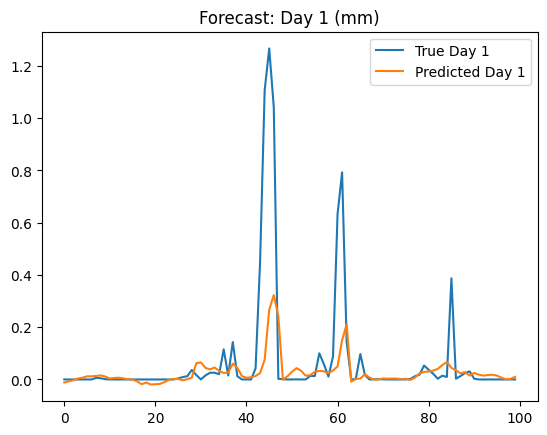

In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test_final[:100, 0], label="True Day 1")
plt.plot(y_pred_final[:100, 0], label="Predicted Day 1")
plt.legend()
plt.title("Forecast: Day 1 (mm)")
plt.show()

In [ ]:
# Great question! Your current model treats all features as a flat multivariate time series per timestep — so it sees the values from nearby points (e.g., tp_north, tp_south, etc.) as just additional features in the input vector, but it doesn’t explicitly understand their spatial relationships or coordinates.

# What happens now?
# The model can learn implicit relationships between variables (including nearby points) through training.

# However, there’s no explicit spatial structure or awareness that, say, “north is physically adjacent to center.”

# Conv1D kernels slide over time, not spatial dimensions, so they capture temporal patterns, not spatial proximity directly.

# Strategies to explicitly incorporate spatial relationships:
# Feature Engineering with Spatial Context:

# Add engineered features like spatial distances or weighted averages of neighbors.

# For example, compute spatially weighted precipitation averages or gradients between points.

# Model Architecture Changes:

# Multi-channel Conv1D:
# Treat each location as a “channel,” like RGB in images:

# Input shape: (seq_len, num_locations * features_per_location)

# Reshape to (seq_len, num_locations, features_per_location) and apply Conv2D (time × space).

# Graph Neural Networks (GNNs):
# Represent locations as nodes with edges based on geographical proximity.

# Allows learning on irregular spatial grids.

# Powerful but requires more complex implementation.

# Spatial Attention Layers:
# Apply attention mechanisms that explicitly attend over spatial locations at each timestep.

# Separate Encoders + Fusion:

# Build separate temporal encoders (Conv1D + Transformer) per location.

# Fuse their outputs (e.g., concatenation, attention) before forecasting.

# This lets the model learn both spatial and temporal representations explicitly.

# A simple step towards spatial-awareness:
# If you want to keep your current time-series model and just give it explicit spatial context, you can:

# Reshape input to (seq_len, num_locations, features_per_location) (e.g., 5 locations × features each).

# Use a Conv2D with kernel shape (time_kernel, space_kernel) to capture spatiotemporal patterns.

# Or, use a separable convolution: Conv1D over time + Conv1D over space.

# Example: Reshape and Conv2D idea
# python
# Copy
# Edit
# # Suppose each timestep has features from 5 locations, each with 5 features
# num_locations = 5
# features_per_location = 5

# # Current input shape: (batch, seq_len, num_locations * features_per_location)
# # Reshape to: (batch, seq_len, num_locations, features_per_location)
# x = tf.reshape(inputs, (-1, seq_len, num_locations, features_per_location))

# # Apply Conv2D: kernels slide over time and space dimensions
# x = Conv2D(filters=64, kernel_size=(3, 2), padding='causal', activation='relu')(x)

# # Then flatten or pool and continue model...
# TL;DR
# No, the current model won’t explicitly model spatial coordinates/relationships.

# You need to design model inputs and architectures to incorporate spatial structure.

# Approaches vary from simple multi-channel convolutions to advanced GNNs or spatial attention.

# If you want, I can help you build a prototype of:

# A multi-location Conv2D hybrid,

# Or a model that treats each location with a separate encoder + fusion,

# Or even sketch a simple GNN approach for spatial structure.

# Would you like to try one of these?